# GPU accelerated solution of the Hydrogen Atom via Gradient Descent


Recently with my sister we discussed about this problem and found out that a sequential naive implementation, was too slow to deliver any usefull result. This solution worked quite well, and it is a nice cross over between different algorithms and techniques: 

The problem itself is about quantum physics, and it is solved through gradient descent, an algorithm that stands at the grounds of machine learning.

Moreover the GPU acceleration, which allows to obtain solutions in few minutes rather than in days, showcase how to use numba to code GPU kernels and how to use the hardware at its full capabilities (with a few limitation that I will explain in the code).



### Some Details about the Theory

This class of problems is in general solved through direct diagonalization of the Hamiltonian operator, since its spectra reflects wave functions and energies of the system.

$$ H \psi = E \psi $$

Unfortunately this is quite demanding considering the size of the matrix. 
We can same memory and computational time by using the gradient descent, at the cost of limiting ourself only to the lowest energy solutions. 

The global minima of the energy corresponds to the lowest eigenvalue of the Hamiltonian matrix, since it is a lower bound for the energy.

Once that is found, we can find the first excited states in the same way, with the additional constraints on keeping the objective state vector orthogonal to the already found solutions.

The Lagrangian / loss function we want to minimize:

$$L = \langle \psi |H| \psi \rangle - \lambda ( \langle \psi | \psi \rangle - 1 ) - \sum_{i} \lambda_{i} \langle \psi | \psi_{i} \rangle $$

The first term represents the total energy, the second one is corresponds to the lagrange multiplier ensuring that the wave function is normalized, and the last term ensures orthogonalization with the other solutions.

### The algorithm

1. Start with a trial wave function  $|\psi\rangle$ orthogonal to the other found solutions 
2. Compute the $\nabla L =  [\nabla L_{\psi}, \nabla L_{\lambda}, \nabla L_{\lambda_{i}} ] $
3. Orthogonalize $\nabla L_{\psi}(\lambda = \langle \psi |H| \psi \rangle)$ with respect to the other solutions obtaining $\nabla \tilde{L}_{\psi}(\lambda = \langle \psi |H| \psi \rangle)$
3. Update $|\psi\rangle \xleftarrow{} |\psi\rangle + \theta \nabla \tilde{L}_{\psi}(\lambda = \langle \psi |H| \psi \rangle )$
4. Repeat from 2 until convergence of the energy $ \langle \psi |H| \psi \rangle$

notice: when evaluating the gradient we put conditions on $\lambda$ and all the $\lambda_{i}$

### Few words about GPU acceleration

I used only the numba decorator ```@cuda.jit``` this represents custom kernels executed on the GPU.
Using premade libraries instead of custom kernel would be more efficient.
The intermediate calls to ```cuda.synchronize()``` were needed to call ```np.dot```.
 ```np.dot``` is executed on the CPU, this means producing communication overhead.
 A better way to deal with this would be to do the matrix multiplications and inner products directly on GPU.
 Unfortunately for lack of time I did not looked further into this.
 
 Moreover the orthogonalization procedure could possibly face memory poblems at the GPU level when many solutions need to be evaluated, hence this part should be addressed more carefully.
 
 ### Final Comment
We obtain the expected results, however it could be possible to improve on how the execution is split between CPU and GPU, and also how the memeory is used.
 Nevertheless to scale up this simple code to multielectron atoms and to more solutions one would just use other theoretical methods such as DFT.

In [1]:
import numpy as np
from numba import cuda
import itertools
import os
import math 
os.environ['CUDA_HOME'] = "/usr/local/cuda-12.4/"

In [2]:
cuda.detect()


Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 3050 Ti Laptop GPU'                              [SUPPORTED]
                      Compute Capability: 8.6
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-68b189a3-95bb-94cc-fe09-34eda2334263
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

In [3]:
# very crude gradient Descent implementation
def gradient_descent(hamiltonian_functor,lowsols,energies, nbas, nsteps, nsol):
   
    #allocate space on GPU
    HpsiGpu   = cuda.device_array(nbas)
    grad      = cuda.device_array(nbas)
    newPsiGpu = cuda.device_array(nbas)
    
    #cuda grid
    if(nbas%8 !=0): raise('Error, wafe function size not a divisor of 8')
    nb = nbas//8 
    nt = 8
    
    
    dd = 0.4 # grid step
    n1D = round(nbas**(1/3)) #number of points per axis
    
    lambd = 0.0
    lambdOld = 1000.0
    
    for isol in range(nsol):
        #gradient update 
        theta = 0.04
        
        #trial w.f. orthogonal to lower energy sol.
        psi = np.random.random(nbas)
        orthog(psi,lowsols,isol, nb,nt)
        psiGpu = cuda.to_device(psi)
        
        #convergence param (Energy)
        lambd = 0.0
        lambdOld = 1000.0
        
        for istep in range(nsteps):
            
            #adapt gradient rate if not minimizing smoothly
            if(lambdOld < lambd ): theta = 0.96*theta
            
            #print something once in a while
            if(istep%200 == 0): print('      ',istep, lambd,n1D)
            
            #convergence criterion
            if(np.abs(lambd-lambdOld)<1e-8): break
            

            hamiltonian_functor[nb,nt](psiGpu, HpsiGpu, dd,n1D)

            cuda.synchronize()
            lambdOld = lambd
            lambd = np.dot(psiGpu,HpsiGpu)

            gradient[nb,nt](HpsiGpu,lambd,psiGpu,grad)
            orthog(grad,lowsols,isol, nb,nt)
            newPsi[nb,nt]( psiGpu,theta,grad)
            cuda.synchronize()
            if(istep%100 == 0): orthog(psiGpu, lowsols,isol,nb,nt)
            cuda.synchronize()
            norm = np.sqrt(np.dot(psiGpu,psiGpu))
            normalize[nb,nt](psiGpu,norm)
            cuda.synchronize()
        print('solution : ',isol, 'E : ', lambd)
        energies.append(lambd)
        lowsols.append(cuda.device_array_like(psiGpu))
        lowsols[isol] = psiGpu
        
#orthogonalize psi with respect to every lowsol and normalizes
def orthog(psi,lowsol,isol, nb,nt):
    for ii in range(isol):
        cuda.synchronize()
        coeff = np.dot(lowsol[ii],psi)
        newPsi[nb,nt](psi,coeff,lowsol[ii])
        cuda.synchronize()
        norm = np.dot(psi,psi)
        normalize[nb,nt]( psi,norm)
    
        
@cuda.jit
def normalize( psiGpu,norm) :
    idx = cuda.grid(1)
    psiGpu[idx] =  psiGpu[idx]/norm
        
@cuda.jit
def newPsi( psiGpu,theta,grad) : 
    idx = cuda.grid(1)
    psiGpu[idx] =  psiGpu[idx] - theta*grad[idx]

@cuda.jit
def gradient(HpsiGpu,lambd,psiGpu,grad)  :  
    idx = cuda.grid(1)
    grad[idx] = HpsiGpu[idx] - lambd*psiGpu[idx]

    
# In general the hamiltonian is a matrix, but since in this case it is very sparse, 
# and we don't need it's explicit form I wrote it as a function.
# In general a matrix is a function between 2 vectors v' = Mv
# it saves us from the memory burden of storing 64^6 floats, 
# considering a grid with 64 points per each dimension
@cuda.jit
def apply_hydrogenatom_h(psi,Hpsi,dd,n1D):
        idx = cuda.grid(1)
        
        tmp = idx
        ijk = cuda.local.array(shape=3,dtype='int32') 
        for ii in range(3):
            ijk[ii] = tmp%n1D
            tmp = tmp//n1D
        
        sx = 1
        sy = n1D
        sz = n1D**2
        nBas = n1D**3
        
        i,j,k = ijk
        
        #slightly moved the center to avoid division by zero
        #not very robust (different grids may cause error)
        x = (i-0.48*n1D)*dd
        y = (j-0.48*n1D)*dd
        z = (k-0.48*n1D)*dd
        
        pot = -1.0/math.sqrt(x**2+y**2+z**2)
        
        Hpsi[idx]    = (pot + 3/(dd**2) )*psi[idx]
        nloc = 0.0
        if(i>1): nloc+= psi[idx-sx]
        if(j>1): nloc+= psi[idx-sy]
        if(k>1): nloc+= psi[idx-sz]
        if(i<n1D-2): nloc+= psi[idx+sx]
        if(j<n1D-2): nloc+= psi[idx+sy]
        if(k<n1D-2): nloc+= psi[idx+sz]
        Hpsi[idx]    -=  0.5*nloc/(dd**2)



The expected energies should respect the following equation according to the main quantum number N

$$E_{n,l,m} = \frac{1}{2}\frac{1}{n^2} $$

The energies are degenerate with respect to $l$ and $m$ quantum numbers (more states with the same energy)

Enumerating the states and the energy as they would be expected:




| n    | l     | m   | E  |
|:----:|:-----:|:---:|:-: |
|  1   |   0|  0 |  0.5   |
|  2   |   0|  0 |  0.125 |
|  2   |   1|  -1|  0.125 |
|  2   |   1|  0 |  0.125 |
|  2   |   1|  1 |  0.125 |
|  3   |  0 |  0 |  0.055 |

and so on ..
These are the energies I obtained

```[-0.4998954080365208, -0.12499329154584318, -0.1251570395034334, -0.12520028032406882, -0.12518735738168, -0.04409995440372703, -0.046681666691438195] ```

The more the energy grows the more the results are off the theoretical ones, as expected.




In [4]:
def main():
        solutions = []
        energies = []
        gradient_descent(apply_hydrogenatom_h,
                         solutions, energies,
                         nbas = 64*64*64, nsteps=10000, 
                         nsol = 7)
        return(solutions,energies)

# remove comment to execute again 
sol, en = main()


       0 0.0 64
       200 -0.46250068828160634 64
       400 -0.49980061825493133 64
solution :  0 E :  -0.49989846515254666
       0 0.0 64


/home/spadetto/.local/lib/python3.8/site-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


       200 9.14256780600535 64
       400 1.1441239725034937 64
       600 2.415103408805086 64
       800 1.6799992190397628 64
       1000 0.30757596164859485 64
       1200 1.1310421953800915 64
       1400 0.0076475206981839365 64
       1600 -0.1058364242386098 64
       1800 0.4850387840774002 64
       2000 0.11130420887630368 64
       2200 -0.10935962897033208 64
       2400 -0.12117131924986518 64
       2600 -0.11210965262268978 64
       2800 -0.10104366569192935 64
       3000 -0.12373889044080907 64
       3200 -0.042211199482532005 64
       3400 -0.06457813566854997 64
       3600 -0.08694095066554235 64
       3800 -0.10929192849097012 64
       4000 -0.11510337497519588 64
       4200 -0.11430017383267539 64
       4400 -0.07450451851447294 64
       4600 -0.0899934153024932 64
       4800 -0.10547808154469171 64
       5000 -0.12094351787159248 64
       5200 -0.11673805712960197 64
       5400 -0.12476536994673008 64
       5600 -0.11193103603174452 64
       5800 -

(64, 64, 64)


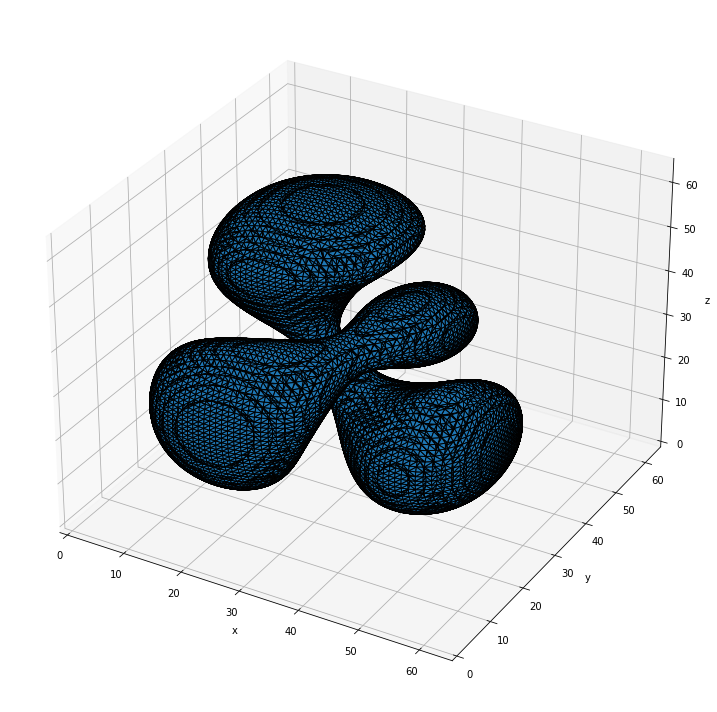

In [5]:
execute = True

#This code is just an example I found here
#https://scikit-image.org/docs/stable/auto_examples/edges/plot_marching_cubes.html


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from skimage import measure
from skimage.draw import ellipsoid

#(you can vary this and plot the corresponding solutions)
#These are the orbitals in principle

# 
# 1s
# 2s 2px 2py 2pz 
# 3s 3px 3py 3pz 3dxx 3dxy ...
if execute: 
    idx = 6
    chosenSol = sol[idx]

    data = np.array(chosenSol.reshape(64,64,64))
    data = data**2

    print(data.shape)

    verts, faces, normals, values = measure.marching_cubes(data, 0.05*(np.max(data)+np.min(data)) )

    # Display resulting triangular mesh using Matplotlib. This can also be done
    # with mayavi (see skimage.measure.marching_cubes docstring).
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    #ax.view_init(elev, azim)
    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces])
    mesh.set_edgecolor('k')
    ax.add_collection3d(mesh)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    ax.set_xlim(0, 64)  # a = 6 (times two for 2nd ellipsoid)
    ax.set_ylim(0, 64)  # b = 10
    ax.set_zlim(0, 64)  # c = 16

    plt.tight_layout()
    plt.savefig(str(idx)+'.png')
    plt.show()
